In [8]:
import numpy as np
import sqlalchemy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [9]:
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore
import sqlalchemy

# connect to the db
dbname = "bde"
port = "5432"
host = "yuma.hpc.nrel.gov"
user = "rlops"
# read the password from a file
passwd_file = '/projects/rlmolecule/rlops_pass'
with open(passwd_file, 'r') as f:
    passwd = f.read().strip()

drivername = "postgresql+psycopg2"
engine_str = f'{drivername}://{user}:{passwd}@{host}:{port}/{dbname}'
engine = sqlalchemy.create_engine(engine_str, execution_options={"isolation_level": "AUTOCOMMIT"})

Session.configure(bind=engine)
session = Session()

In [59]:
# run_id = 'stable_radical_optimization_psj_NO_l'
run_id = 'stable_rad_debug_no_cache3'

df_rewards = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
df_data = pd.DataFrame(df_rewards.data.tolist())
df_rewards = df_rewards.join(df_data)

# df_rewards['smiles'] = df_rewards.data.apply(lambda x: x['smiles'])

In [76]:
import rdkit
from tqdm import tqdm
tqdm.pandas()

df_rewards['num_atoms'] = df_rewards.smiles.progress_apply(lambda x: rdkit.Chem.MolFromSmiles(x).GetNumAtoms())

100%|██████████| 3388743/3388743 [02:53<00:00, 19512.05it/s]


In [79]:
df_rewards.ionization_energy = df_rewards.ionization_energy.astype(float)
df_rewards.electron_affinity = df_rewards.electron_affinity.astype(float)

In [75]:
# smarts = rdkit.Chem.MolFromSmarts('C(-[CH3])(-[CH3])-[NR1](-[OX1])-C(-[CH3])(-[CH3])')
smarts = rdkit.Chem.MolFromSmarts('C([CR0])([CR0])-[NR1](-[OX1])-[C,N]([CR0])')
has_match = df_data.smiles.progress_apply(lambda x: rdkit.Chem.MolFromSmiles(x).HasSubstructMatch(smarts))

  1%|▏         | 50825/3388743 [00:02<02:35, 21483.99it/s]


KeyboardInterrupt: 

In [80]:
matching_mols = df_rewards[has_match]
matching_mols.shape

(57433, 15)

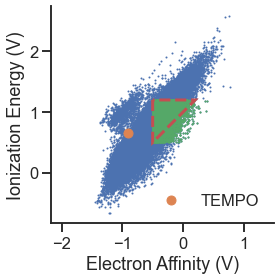

In [81]:
from matplotlib.patches import Polygon

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
ax.set_adjustable('datalim')

ax.add_patch(Polygon(np.array([(-.5, 1.2), (-.5, 0.5), (.2, 1.2)]), facecolor='none', zorder=5, edgecolor='r', lw=3, ls='--'))

ax.plot(matching_mols.electron_affinity, matching_mols.ionization_energy, '.', ms=2)


to_calc = matching_mols[(matching_mols.ionization_energy < 1.2) &
                        (matching_mols.ionization_energy > .5) & 
                        (matching_mols.electron_affinity > -.5)]


ax.plot(to_calc.electron_affinity, to_calc.ionization_energy, 'g.', ms=2)


ax.plot(-0.906452, 0.655321, 'o', label='TEMPO')

ax.set_xlabel('Electron Affinity (V)')
ax.set_ylabel('Ionization Energy (V)')
ax.legend()

sns.despine()
fig.tight_layout()

# ax1.set_xlim([-1.5, 1.5])
# ax1.set_ylim([-1, 2])

In [108]:
tmp = to_calc[to_calc.reward > 190].sort_values(['num_atoms', 'reward'], ascending=[True, False])[['smiles', 'reward', 'num_atoms', 'ionization_energy', 'electron_affinity']].head(20)

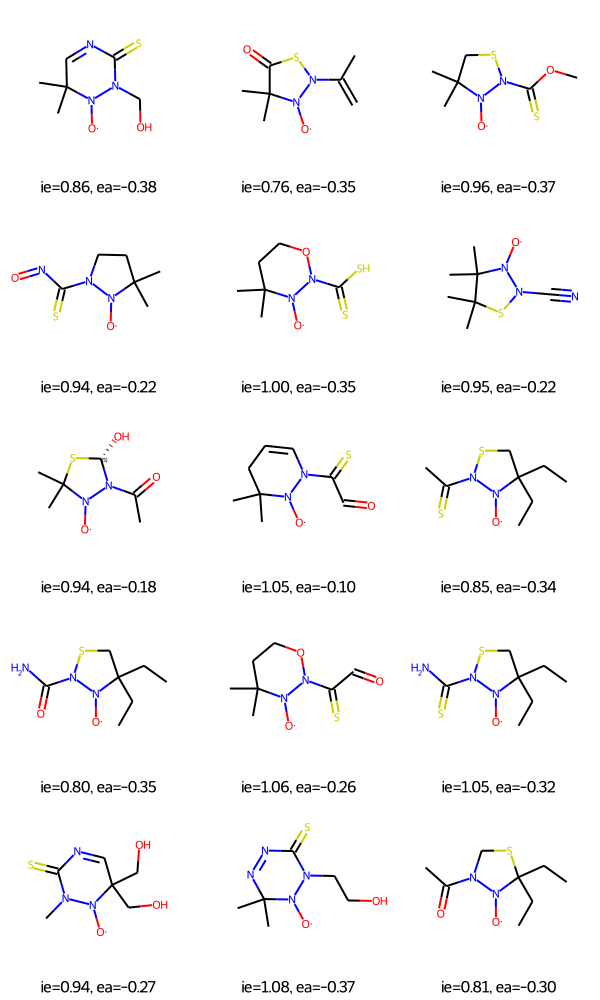

In [109]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image

mols = list(tmp.smiles.apply(rdkit.Chem.MolFromSmiles))
d2d = rdMolDraw2D.MolDraw2DCairo(200*3,200*5,200,200)
d2d.drawOptions().fixedBondLength=5
d2d.drawOptions().addStereoAnnotation=True
d2d.DrawMolecules(mols, legends=[f'ie={row.ionization_energy:.2f}, ea={row.electron_affinity:.2f}' for _, row in tmp.iterrows()])
d2d.FinishDrawing()
Image(d2d.GetDrawingText())

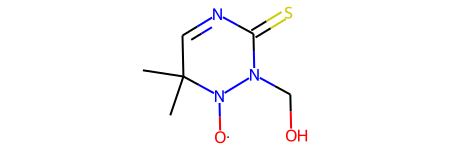

In [105]:
rdkit.Chem.MolFromSmiles('CC1(C)C=NC(=S)N(CO)N1[O]')

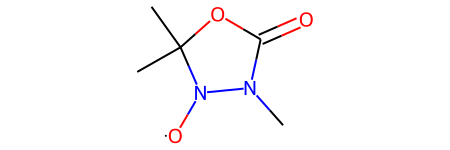

In [89]:
rdkit.Chem.MolFromSmiles('CN1C(=O)OC(C)(C)N1[O]')

In [27]:
rdkit.Chem.MolToSmiles(rdkit.Chem.MolFromSmiles('CC1(CCCC(N1[O])(C)C)C'))

'CC1(C)CCCC(C)(C)N1[O]'

In [28]:
matching_mols[(matching_mols.smiles == 'CC1(C)CCCC(C)(C)N1[O]')]

,forced_terminal,smiles,max_spin,spin_buried_vol,ionization_energy,electron_affinity,bde,bde_diff


In [29]:
matching_mols['num_atoms'] = matching_mols.smiles.apply(lambda x: rdkit.Chem.MolFromSmiles(x).GetNumAtoms())

<ipython-input-29-9f3983ef4601>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_mols['num_atoms'] = matching_mols.smiles.apply(lambda x: rdkit.Chem.MolFromSmiles(x).GetNumAtoms())


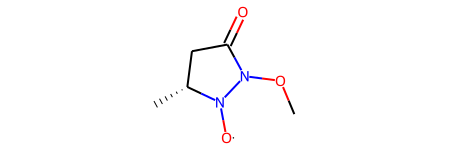

In [49]:
rdkit.Chem.MolFromSmiles('CON1C(=O)C[C@@H](C)N1[O]')

In [31]:
matching_mols.sort_values('num_atoms')

,forced_terminal,smiles,max_spin,spin_buried_vol,ionization_energy,electron_affinity,bde,bde_diff,num_atoms
641937,True,CC1(C)N([O])C1(C)C,0.5150662,34.521122,0.948469,-0.494263,76.925575,21.154953,8
1379446,True,CC1(C)N=NC(C)(C)N1[O],0.48782033,60.216137,1.204556,-1.042104,66.09044,35.191246,10
1426399,True,CC1(C)NNC(C)(C)N1[O],0.47342527,61.642223,0.981030,-1.039575,68.44847,9.809013,10
1432281,True,CC1(C)NN(S)C(C)(C)N1[O],0.43802765,62.74002,1.049737,-1.019217,68.14537,9.514915,11
1441624,True,CN1NC(C)(C)N([O])C1(C)C,0.44787374,63.033184,0.976172,-1.067717,67.51816,5.9510803,11
...,...,...,...,...,...,...,...,...,...
1491671,True,CN(S)N1C(=S)NC(C)(C)N([O])C1(C)C,0.49720576,43.72893,0.987097,-0.908642,71.54166,5.785866,15
1491672,True,CN1NC(C)(C)N([O])C(C)(C)N(CO)S1,0.47470596,44.99625,0.712085,-1.099185,70.9425,11.033592,15
1491673,True,C=CCN(S)N1NC(C)(C)N([O])C1(C)C,0.44338742,62.930138,1.052162,-1.013787,67.700195,8.394493,15
1488860,True,C=C(NO)NN1NC(C)(C)N([O])C1(C)C,0.45131314,62.577675,1.082891,-0.979572,68.40136,0.31511688,15


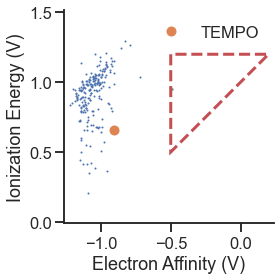

In [38]:
matching_mols.sort_values('electron_affinity', ascending=False)

,forced_terminal,smiles,max_spin,spin_buried_vol,ionization_energy,electron_affinity,bde,bde_diff,num_atoms
641937,True,CC1(C)N([O])C1(C)C,0.5150662,34.521122,0.948469,-0.494263,76.925575,21.154953,8
1432297,True,CN1OC(=O)/C=N\C(C)(C)N([O])C1(C)C,0.4554885,45.262016,1.038897,-0.723648,71.856735,21.535393,15
1451283,True,CC1(C)N=NN(N=O)C(C)(C)N1[O],0.4589062,43.69268,1.263418,-0.791553,71.63124,29.070496,13
1464217,True,CC1(C)N=NN(C#N)C(C)(C)N1[O],0.49766332,43.767216,1.297218,-0.825943,71.75133,28.950409,13
1451275,True,CC1(C)N=NN(C(=O)OS)C(C)(C)N1[O],0.49967304,45.123875,1.246383,-0.853479,71.77957,15.957909,15
...,...,...,...,...,...,...,...,...,...
1493978,True,CCN1N(S)CNC(C)(C)N([O])C1(C)C,0.44248763,45.35777,0.865831,-1.186506,70.74962,6.2816467,15
1496154,True,CN1CCN(S)NC(C)(C)N([O])C1(C)C,0.46776295,44.68378,0.945579,-1.186796,70.86758,6.5139465,15
1494962,True,CN1CN(S)N(C)C(C)(C)N([O])C1(C)C,0.4842101,45.27988,0.950116,-1.197565,71.53032,4.265297,15
1495232,True,CN1N(S)CCNC(C)(C)N([O])C1(C)C,0.45682675,44.734955,0.854430,-1.205758,71.056656,6.625252,15


In [33]:
to_calc

,forced_terminal,smiles,max_spin,spin_buried_vol,ionization_energy,electron_affinity,bde,bde_diff,num_atoms
641937,True,CC1(C)N([O])C1(C)C,0.5150662,34.521122,0.948469,-0.494263,76.925575,21.154953,8


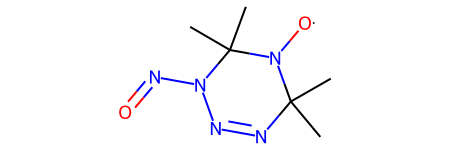

In [40]:
rdkit.Chem.MolFromSmiles('CC1(C)N=NN(N=O)C(C)(C)N1[O]')

<AxesSubplot:ylabel='Frequency'>

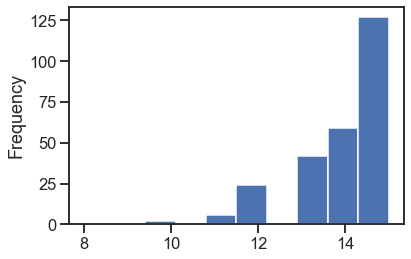

In [63]:
to_calc.sort_values('num_atoms').num_atoms.plot.hist()

In [84]:
matching_mols.to_csv('/projects/rlmolecule/pstjohn/tempo/tempo_predictions.csv', index=False)

In [73]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import Image

to_plot = to_calc.sort_values('num_atoms').head(20)

mols = list(to_plot.smiles.apply(rdkit.Chem.MolFromSmiles))
d2d = rdMolDraw2D.MolDraw2DCairo(200*3,200*5,200,200)
d2d.drawOptions().fixedBondLength=5
d2d.drawOptions().addStereoAnnotation=True
d2d.DrawMolecules(mols, legends=[f'ie={row.ionization_energy:.2f}, ea={row.electron_affinity:.2f}' for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
Image(d2d.GetDrawingText())

In [78]:
mols_for_dft = to_calc.sort_values('num_atoms').smiles.tolist()

In [ ]:
mols_for_dft

In [85]:
pd.Series(['CC1(C)CC(C)(C)N1[O]', 'CC1(C)CCC(C)(C)N1[O]', 'CC1(C)CCCC(C)(C)N1[O]'] + mols_for_dft
         ).to_csv('/projects/rlmolecule/pstjohn/tempo/to_calc.csv', index=False)